In [870]:
import pandas as pd
import numpy as np
import datetime
import time
import seaborn as sns
from matplotlib import pyplot


In [871]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score
from sklearn.cluster import KMeans

In [1362]:
#read in the pre-processed training and test set from Dmitri's notebook
X_train = pd.read_csv("data/X_train_random_1592420882.csv")
Y_train = pd.read_csv("data/Y_train_random_1592420882.csv")
X_test = pd.read_csv("data/X_test_random_1592420882.csv")
Y_test = pd.read_csv("data/Y_test_random_1592420882.csv")

In [1364]:
assert((X_train.shape[0] == Y_train.shape[0]) & (X_test.shape[0] == Y_test.shape[0]))

In [1365]:
print(f'Dim of X_train: {X_train.shape}')
print(f'Dim of Y_train: {Y_train.shape}')
print("\n")
print(f'Dim of X_test: {X_test.shape}')
print(f'Dim of Y_test: {Y_test.shape}')

Dim of X_train: (1076080, 37)
Dim of Y_train: (1076080, 2)


Dim of X_test: (269020, 37)
Dim of Y_test: (269020, 2)


In [1366]:
print(f'Train-test split: [{X_train.shape[0]/(X_train.shape[0] + X_test.shape[0])},\
{X_test.shape[0]/(X_train.shape[0] + X_test.shape[0])}]')

Train-test split: [0.8,0.2]


In [1367]:
X_train.columns

Index(['id', 'application_type', 'grade', 'sub_grade', 'term',
       'initial_list_status', 'emp_length', 'verification_status', '_has_desc',
       'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'fico_range_low',
       'delinq_2yrs', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       '_credit_hist', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'home_ownership_OTHER',
       'home_ownership_OWN', 'home_ownership_RENT'],
      dtype='object')

In [1368]:
X_train.head(2)

,id,application_type,grade,sub_grade,term,initial_list_status,emp_length,verification_status,_has_desc,loan_amnt,...,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,55299945,0,2,9,0,1,10,1,0,6000.0,...,0,0,0,0,0,0,0,0,0,0
1,1036827,0,2,7,0,1,9,2,1,20000.0,...,0,0,0,0,0,0,0,0,0,1


In [1369]:
np.mean(Y_train.id == X_train.id)

1.0

In [1370]:
np.mean(Y_test.id == X_test.id)

1.0

In [1371]:
##we need to get fields needed for return calculations.
#LC_df = pd.read_csv("data/accepted_2007_to_2018Q4.csv")

In [1372]:
ret_df = LC_df[["id", "issue_d","last_pymnt_d", "total_pymnt", "term", "funded_amnt", "recoveries"]].copy()

In [1373]:
ret_df.term.value_counts(dropna=False)

 36 months    1609754
 60 months     650914
NaN                33
Name: term, dtype: int64

In [1374]:
ret_df.dropna(subset=["id", "issue_d","last_pymnt_d", "total_pymnt", "term", "funded_amnt"], inplace=True)

In [1375]:
#convert term field to integer months
ret_df['term'] = ret_df['term'].apply(lambda t: np.int8(t.split()[0]))
ret_df.term.value_counts()


36    1607966
60     650275
Name: term, dtype: int64

In [1376]:
ret_df[["total_pymnt", "funded_amnt", "recoveries"]].describe().T

,count,mean,std,min,25%,50%,75%,max
total_pymnt,2258241.0,12094.073850,9900.144164,10.0,4560.85,9343.69,16951.677553,63296.877917
funded_amnt,2258241.0,15041.772723,9186.916012,500.0,8000.00,12875.00,20000.000000,40000.000000
recoveries,2258241.0,142.565584,743.233625,0.0,0.00,0.00,0.000000,39859.550000


In [1377]:
#convert issue_d and last_pymnt_d into datetime
ret_df['issue_d'] = ret_df['issue_d'].apply(lambda dt: datetime.datetime.strptime( dt, "%b-%Y").date())
ret_df['last_pymnt_d'] = ret_df['last_pymnt_d'].apply(lambda dt: datetime.datetime.strptime( dt, "%b-%Y").date())

In [1378]:
#calculate the realized term of the loan in months. 
ret_df['realized_loan_term_mths'] = round((ret_df['last_pymnt_d'] - ret_df['issue_d'])/np.timedelta64(1, 'M'))

In [1379]:
#where realized_loan_term_mths != term means default or pre-payment
np.sum(ret_df.realized_loan_term_mths != ret_df.term)/ret_df.shape[0]

0.9240351229120364

In [1380]:
#remove rows where realized_loan_term_mths = 0
ret_df = ret_df[ret_df.realized_loan_term_mths > 0]

Function calc_return(....)

    calculate the effective(realized) annualized return on the funded amount of a loan
    assumption 1: monthly cash flow can be invested at a monthly rate of return rr
    This assumption allows us to simplify the return calculation to a sum of a geometric series
    with cash payments of: m, m(1+rr), m(1+rr)^2, m(1+rr)^3, ...,m(1+rr)^(last_pymnt_d -1) at the 
    end of months: 0,1,2,3,...last_pyment_d - 1 respectively
    The sequence of cash flows then forms a geometric series of the form
                                        a + ar + ar2 + ... + ar(n-1)
                                        which has a closed form sum:
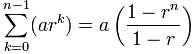

    where r = (1+rr) and a = m, the effective monthly installment payment over the actual life of the loan.
    
    assumption 2: when loan terminates early(due to default or pre-payment) total cash received
    + accrued interest are re-invested at the same rate rr from that time till the term of the loan

In [1381]:
def calc_return(total_pymnt, term, funded_amnt, recoveries, realized_loan_term_mths, r=0.01):
    effective_monthly_installments = (total_pymnt - recoveries)/realized_loan_term_mths
    
    #get total cash flow at loan termination as the geometric sum of effective monthly installments
    #yielding a constant rate of return rr.
    #This is from assumption #1
    rr =r/12 #expecting r to be the annual yield
    total_cash_flow = effective_monthly_installments * ((1 - (1 + rr)**realized_loan_term_mths)) / (1 - (1 + rr))
    
    #add back recoveries to the get the lump sum at loan termination.
    total_cash_flow+= recoveries 

    #assumption #2. invest at rr till original term of loan.
    total_cash_flow = total_cash_flow * ((1 + rr)**(max(0,term - realized_loan_term_mths)))
    
    #calculate total return R and annualize
    R = (total_cash_flow - funded_amnt) / funded_amnt
    return ((1+R)**(12/term) - 1)


In [1382]:
rr = 0.01
ret_df["annualized_returns"] = ret_df.apply(lambda row: calc_return(row[3], row[4], row[5], row[6], row[7], rr), axis =1)

In [1383]:
ret_df.shape

(2249276, 9)

In [1384]:
ret_df = ret_df.astype({'id': 'int64'})


In [1385]:
ret_df.sample(10)

,id,issue_d,last_pymnt_d,total_pymnt,term,funded_amnt,recoveries,realized_loan_term_mths,annualized_returns
1463715,141538045,2018-10-01,2019-01-01,1031.675821,36,1000.0,0.00,3.0,0.020033
645713,112747034,2017-07-01,2018-05-01,7353.840000,60,32000.0,0.00,10.0,-0.248003
962989,104612657,2017-04-01,2018-07-01,8032.210000,60,17600.0,1985.24,15.0,-0.138010
1581642,131996056,2018-04-01,2019-03-01,3136.300000,60,13000.0,0.00,11.0,-0.240720
888690,110355577,2017-06-01,2018-11-01,18453.302379,36,17000.0,0.00,17.0,0.035457
619165,113490331,2017-07-01,2019-03-01,995.400000,36,1500.0,0.00,20.0,-0.121560
107787,61982404,2015-10-01,2018-11-01,8609.036232,36,7000.0,0.00,37.0,0.076784
96120,63144202,2015-10-01,2018-11-01,22982.850910,36,20000.0,0.00,37.0,0.052691
295867,47572141,2015-05-01,2019-03-01,26733.250000,60,25000.0,0.00,46.0,0.019691
2002945,86326351,2016-07-01,2016-11-01,36519.790001,36,35000.0,0.00,4.0,0.023748


In [1386]:
def fit_return_models(X_train, Y_train, X_test, Y_test, model_name ="Ridge",
                      cv_parameters = {},
                      random_state = 1980):
    '''
    fits 2 return models using the sklearn model object implied by model name. One model for loans that defaulted and another for 
    loans that didn't default.
    code borrowed mostly from the danguetta.com paper/notebook.
    '''
    
    np.random.seed(random_state)
    
    #choose model based on user selection
    if model_name == "Lasso":
        model = linear_model.Lasso(normalize=True)
    elif model_name == "Ridge":
        model = linear_model.Ridge(normalize=True)
    elif model_name == "RandomF":
        model = RandomForestRegressor()

    
 
    #split data into defaulted series and non-defaulted series

    Y_train_bad = Y_train.loc[(Y_train._good == 0),['id', 'annualized_returns'] ]
    X_train_bad = X_train[X_train.id.isin(Y_train_bad.id)]
    Y_test_bad  = Y_test.loc[(Y_test._good == 0),['id', 'annualized_returns'] ]
    X_test_bad  = X_test[X_test.id.isin(Y_test_bad.id)]
    
    Y_train_good = Y_train.loc[(Y_train._good == 1),['id', 'annualized_returns'] ]
    X_train_good = X_train[X_train.id.isin(Y_train_good.id)]  
    Y_test_good  = Y_test.loc[(Y_test._good == 1),['id', 'annualized_returns'] ]
    X_test_good  = X_test[X_test.id.isin(Y_test_good.id)]

    
    ##remove ids for now to be added back afterwards
    train_bad_loan_ids = X_train_bad.pop('id')
    test_bad_loan_ids = pd.DataFrame(X_test_bad.pop('id'), columns=['id'])


    train_good_loan_ids = X_train_good.pop('id')
    test_good_loan_ids = pd.DataFrame(X_test_good.pop('id'), columns=['id'])
    

    
    ##drop ids from Y datasets
    Y_train_good.drop('id', axis =1, inplace=True)
    Y_train_bad.drop('id', axis=1, inplace=True)
    
    Y_test_good.drop('id', axis =1, inplace=True)
    Y_test_bad.drop('id', axis =1, inplace=True)
    

    
    ##run model
    cv_model_bad = GridSearchCV(model, cv_parameters, scoring='r2')
    cv_model_good = GridSearchCV(model, cv_parameters, scoring='r2')

    #time and fit the models
    start_time = time.time()
    print("fitting model for defaulted loans")
    if model_name in ['RandomF']:
        cv_model_bad.fit(X_train_bad, Y_train_bad.values.ravel())
    else:
        cv_model_bad.fit(X_train_bad, Y_train_bad)
        
    print("fitting model for non-defaulted loans")
    if model_name in ['RandomF']:
        cv_model_good.fit(X_train_good, Y_train_good.values.ravel())
    else:
        cv_model_good.fit(X_train_good, Y_train_good)
        
    end_time = time.time()

    #pick best model from the fit for each regressor
    best_model_bad = cv_model_bad.best_estimator_
    best_model_good = cv_model_good.best_estimator_
            
    #tidy outputs    
    print("=========================")
    print("  Model: " + model_name )
    print("=========================")

    print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
    print("Optimal parameters:")
    print("model_default:",cv_model_bad.best_params_, "model_non-default",cv_model_good.best_params_)

    ##predicted returns - need to join back to get loan ids
    predicted_non_default_return = pd.DataFrame(best_model_good.predict(X_test_good), columns =['ret'])
    predicted_default_return     = pd.DataFrame(best_model_bad.predict(X_test_bad), columns =['ret'])
    
    
    ## add ids back
    predicted_non_default_return = list(zip(test_good_loan_ids.id, predicted_non_default_return.ret))
    
    predicted_default_return = list(zip(test_bad_loan_ids.id, predicted_default_return.ret))
    
    print("")
    print("Testing r2 scores:")
    # Here we use different testing set to report the performance
    test_scores = {'model_default':r2_score(Y_test_bad,best_model_bad.predict(X_test_bad)),
                      'model_non_default':r2_score(Y_test_good,best_model_good.predict(X_test_good))}
 
    print("model_default:", test_scores['model_default'])
    print("model_non_default:", test_scores['model_non_default'])

    return { 'model_default':best_model_bad, 'model_non_default':best_model_good, 'predicted_non_default_return':predicted_non_default_return,
              'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

    
    


### Testing stuff


In [1387]:
ret_df.head(2)

,id,issue_d,last_pymnt_d,total_pymnt,term,funded_amnt,recoveries,realized_loan_term_mths,annualized_returns
0,68407277,2015-12-01,2019-01-01,4421.723917,36,3600.0,0.0,37.0,0.076315
1,68355089,2015-12-01,2016-06-01,25679.660000,36,24700.0,0.0,6.0,0.022233


In [1388]:
my_X_train = X_train.copy()
my_Y_train = Y_train.copy()

my_X_test = X_test.copy()
my_Y_test = Y_test.copy()

In [1389]:
#merge returns data
my_Y_train = pd.merge(my_Y_train, ret_df[['id','annualized_returns']], how="left", on ='id')
my_Y_test = pd.merge(my_Y_test, ret_df[['id','annualized_returns']], how="left", on ='id')


In [1390]:
my_Y_test.isnull().sum(axis=0)

id                       0
_good                    0
annualized_returns    2253
dtype: int64

In [1391]:
my_Y_train.dropna(inplace=True)
my_Y_test.dropna(inplace=True)

In [1392]:
np.logspace(-8, 1, num = 10)

array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01])

## Test regression models


### Ridge

In [1393]:
cv_parameters = {'alpha': np.logspace(-8, 2, num = 10), 'max_iter' : [2000]}

reg_ridge = fit_return_models(my_X_train, my_Y_train, my_X_test, my_Y_test, model_name ="Ridge",
               cv_parameters = cv_parameters)

fitting model for defaulted loans
fitting model for non-defaulted loans
  Model: Ridge
Fit time: 33.94 seconds
Optimal parameters:
model_default: {'alpha': 2.1544346900318867e-05, 'max_iter': 2000} model_non-default {'alpha': 1.6681005372000591e-06, 'max_iter': 2000}

Testing r2 scores:
model_default: 0.09609842763909493
model_non_default: 0.3688380393363825


In [1394]:
list_ids, returns_non_defaults = zip(*reg_ridge['predicted_non_default_return'])
list_ids, returns_defaults = zip(*reg_ridge['predicted_default_return'])

actual_defaults  = my_Y_test.loc[(my_Y_test._good == 0),['annualized_returns']]
actual_non_defaults = my_Y_test.loc[(my_Y_test._good == 1),['annualized_returns']]


In [1395]:
print("Means of various populations, actual vs. pred:")
print("-"*50)
print(f'actual_non_defaults:{np.mean(actual_non_defaults.annualized_returns):.4f}')
print(f'predicted_non_defaults:{np.mean(returns_non_defaults):.4f}')
print("\n")
print(f'actual_defaults:{np.mean(actual_defaults.annualized_returns):.4f}')
print(f'predicted_defaults:{np.mean(returns_defaults):.4f}')

Means of various populations, actual vs. pred:
--------------------------------------------------
actual_non_defaults:0.0506
predicted_non_defaults:0.0506


actual_defaults:-0.1729
predicted_defaults:-0.1727


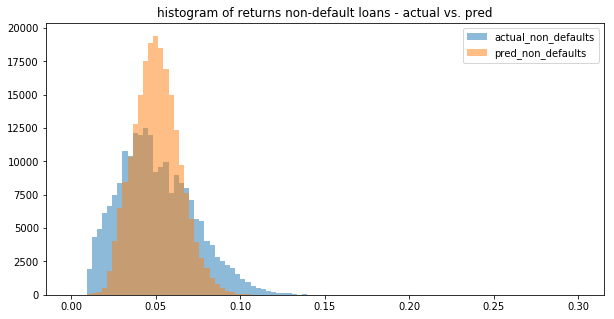

In [1396]:
bins = np.linspace(-0., 0.3, 100)

pyplot.hist(actual_non_defaults.annualized_returns, bins, alpha=0.5, label='actual_non_defaults')

pyplot.hist(returns_non_defaults, bins, alpha=0.5, label='pred_non_defaults')

pyplot.legend(loc='upper right')
pyplot.title("histogram of returns non-default loans - actual vs. pred")
pyplot.show()

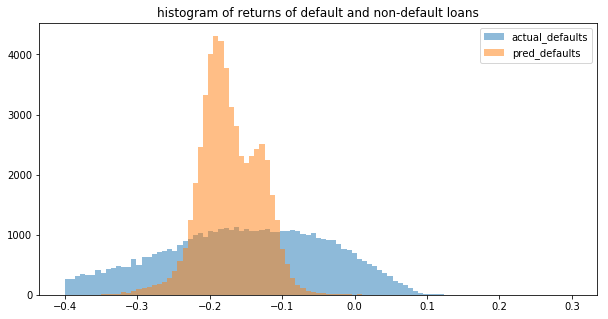

In [1397]:
bins = np.linspace(-0.4, 0.3, 100)

pyplot.hist(actual_defaults.annualized_returns,  bins, alpha=0.5, label='actual_defaults')
pyplot.hist(returns_defaults,  bins, alpha=0.5, label='pred_defaults')
pyplot.legend(loc='upper right')
pyplot.title("histogram of returns of default and non-default loans")
pyplot.show()

In [1398]:
np.sum(returns_non_defaults * actual_non_defaults.annualized_returns<0)

9

In [1399]:
(np.sum(returns_non_defaults * actual_non_defaults.annualized_returns<0))/actual_non_defaults.shape[0]

4.214627567410626e-05

### Random Forest

In [1400]:
# #to be fine tuned...but too slow on my mac. took 40+mins to run!
# cv_parameters = {'min_samples_leaf':[75],
#                  'n_estimators': [35] }

# reg_rf = fit_return_models(my_X_train, my_Y_train, my_X_test, my_Y_test, model_name ="RandomF",
#                cv_parameters = cv_parameters)

In [1401]:
my_X_train.columns

Index(['id', 'application_type', 'grade', 'sub_grade', 'term',
       'initial_list_status', 'emp_length', 'verification_status', '_has_desc',
       'loan_amnt', 'int_rate', 'installment', 'annual_inc', 'fico_range_low',
       'delinq_2yrs', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       '_credit_hist', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'home_ownership_OTHER',
       'home_ownership_OWN', 'home_ownership_RENT'],
      dtype='object')

In [1402]:
my_Y_train.columns

Index(['id', '_good', 'annualized_returns'], dtype='object')

In [1403]:
#### create risk data.
risk_data_train = pd.merge(my_X_train[['id', 'grade', 'sub_grade', 'term']], my_Y_train, how='inner', on='id')

In [1404]:
risk_data_train.isnull().sum(axis=0)

id                    0
grade                 0
sub_grade             0
term                  0
_good                 0
annualized_returns    0
dtype: int64

In [1405]:
##create risk scores

def var_95(ret):
    return np.percentile(ret,  5)

def var_99(ret):
    return np.percentile(ret, 1)

def ES_95(ret):
    threshold = var_95(ret)
    return np.mean(ret[ret < threshold])

def ES_99(ret):
    threshold = var_99(ret)
    return np.mean(ret[ret < threshold])



In [1406]:
#risk_summary_grades_all = pd.DataFrame(risk_data_train.groupby(['grade'])['annualized_returns'].agg(['count', 'median' , 'mean', 'min','max', 'std', var_95, var_99, ES_95, ES_99])).reset_index()

#risk_summary_grades_all

In [1407]:
risk_summary_sub_grades_all = pd.DataFrame(risk_data_train.groupby(['sub_grade'])['annualized_returns'].agg(['count', 'median' , 'mean', 'min','max', 'std', var_95, var_99, ES_95, ES_99])).reset_index()
risk_summary_sub_grades_all

,sub_grade,count,median,mean,min,max,std,var_95,var_99,ES_95,ES_99
0,1,34779,0.030333,0.020723,-0.687966,0.042983,0.049367,0.012411,-0.259929,-0.127989,-0.386784
1,2,29500,0.034469,0.020931,-0.819906,0.047955,0.058842,0.010956,-0.308331,-0.182821,-0.428543
2,3,30080,0.036693,0.020874,-0.686280,0.048816,0.064810,-0.020443,-0.342782,-0.223175,-0.440583
3,4,41512,0.038676,0.020043,-0.693389,0.079302,0.070749,-0.080901,-0.362112,-0.255642,-0.456721
4,5,50856,0.040928,0.019567,-0.685492,0.057919,0.075916,-0.128070,-0.366509,-0.278064,-0.462381
5,6,56528,0.041014,0.016510,-0.683878,0.088621,0.083674,-0.173348,-0.388188,-0.305591,-0.471374
6,7,58663,0.045526,0.018601,-0.908308,0.068227,0.086486,-0.187265,-0.385232,-0.308618,-0.468465
7,8,64908,0.048125,0.018104,-0.698089,0.081912,0.092127,-0.207417,-0.387001,-0.321183,-0.477147
8,9,66047,0.049149,0.016121,-0.834690,0.108618,0.097259,-0.222883,-0.396369,-0.331764,-0.478662
9,10,65596,0.048730,0.011089,-0.683220,0.108635,0.106222,-0.253178,-0.415415,-0.355519,-0.499520


In [1408]:
risk_summary_sub_grades_3yr = pd.DataFrame(risk_data_train.loc[(risk_data_train.term == 0)].\
                                           groupby(['sub_grade'])['annualized_returns'].\
                                           agg(['count', 'median' , 'mean', 'min','max', 'std',\
                                           var_95, var_99, ES_95, ES_99])).reset_index()
risk_summary_sub_grades_3yr

,sub_grade,count,median,mean,min,max,std,var_95,var_99,ES_95,ES_99
0,1,34732,0.030348,0.020750,-0.687966,0.042983,0.049324,0.012423,-0.259009,-0.127743,-0.386330
1,2,29351,0.034531,0.020986,-0.819906,0.047955,0.058868,0.010979,-0.311326,-0.182389,-0.428947
2,3,29912,0.036742,0.020966,-0.686280,0.048816,0.064718,-0.019700,-0.342725,-0.222312,-0.440065
3,4,40350,0.039054,0.020537,-0.693389,0.079302,0.070301,-0.075060,-0.354275,-0.252914,-0.456096
4,5,47445,0.041689,0.020100,-0.685492,0.057919,0.076508,-0.124548,-0.382836,-0.280930,-0.467342
5,6,50686,0.042463,0.017856,-0.683878,0.088621,0.083972,-0.170221,-0.391228,-0.307948,-0.477242
6,7,52423,0.047456,0.020158,-0.908308,0.068227,0.086736,-0.182293,-0.386758,-0.310765,-0.474009
7,8,56360,0.050401,0.020098,-0.698089,0.081912,0.092796,-0.206975,-0.398297,-0.326835,-0.487234
8,9,56434,0.051601,0.017794,-0.834690,0.108618,0.099027,-0.233753,-0.412288,-0.340724,-0.487702
9,10,57925,0.050938,0.012869,-0.683220,0.108635,0.107108,-0.254592,-0.422579,-0.360567,-0.506408


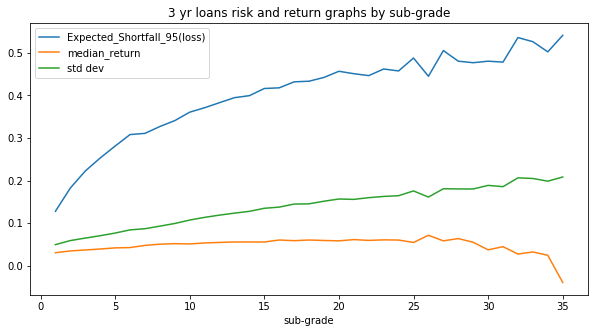

In [1409]:
pyplot.rcParams['figure.figsize'] = [10, 5]

pyplot.plot(risk_summary_sub_grades_3yr.sub_grade, abs(risk_summary_sub_grades_3yr.ES_95))
pyplot.plot(risk_summary_sub_grades_3yr.sub_grade, risk_summary_sub_grades_3yr['median'])
pyplot.plot(risk_summary_sub_grades_3yr.sub_grade, risk_summary_sub_grades_3yr['std'])
#pyplot.plot(risk_summary_sub_grades_3yr.sub_grade, (risk_summary_sub_grades_3yr['median']/abs(risk_summary_sub_grades_3yr.ES_95)))

pyplot.legend(['Expected_Shortfall_95(loss)', 'median_return', 'std dev'], loc='upper left')
pyplot.title('3 yr loans risk and return graphs by sub-grade')
pyplot.xlabel('sub-grade')
pyplot.show()

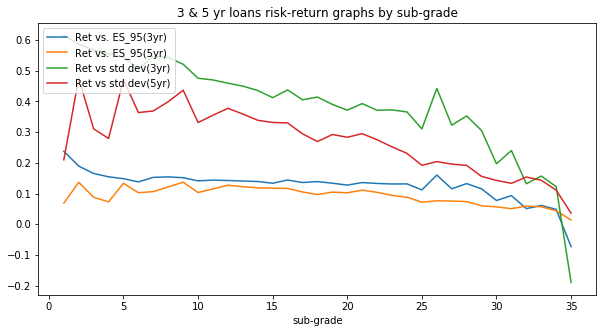

In [1410]:
pyplot.rcParams['figure.figsize'] = [10, 5]

pyplot.plot(risk_summary_sub_grades_3yr.sub_grade, (risk_summary_sub_grades_3yr['median']/abs(risk_summary_sub_grades_3yr.ES_95)))
pyplot.plot(risk_summary_sub_grades_5yr.sub_grade, (risk_summary_sub_grades_5yr['median']/abs(risk_summary_sub_grades_5yr.ES_95)))

pyplot.plot(risk_summary_sub_grades_3yr.sub_grade, (risk_summary_sub_grades_3yr['median']/risk_summary_sub_grades_3yr['std']))
pyplot.plot(risk_summary_sub_grades_5yr.sub_grade, (risk_summary_sub_grades_5yr['median']/risk_summary_sub_grades_5yr['std']))

pyplot.legend(['Ret vs. ES_95(3yr)', 'Ret vs. ES_95(5yr)', 'Ret vs std dev(3yr)', 'Ret vs std dev(5yr)'], loc='upper left')
pyplot.title('3 & 5 yr loans risk-return graphs by sub-grade')
pyplot.xlabel('sub-grade')
pyplot.show()

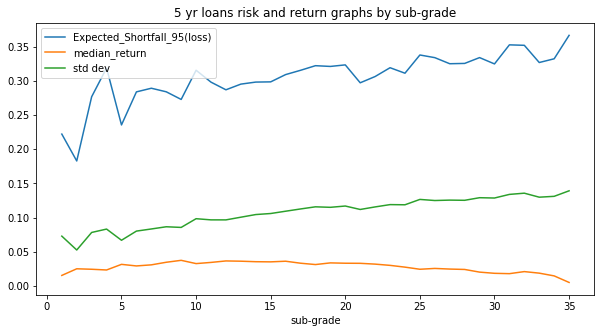

In [1411]:
pyplot.rcParams['figure.figsize'] = [10, 5]

pyplot.plot(risk_summary_sub_grades_5yr.sub_grade, abs(risk_summary_sub_grades_5yr.ES_95))
pyplot.plot(risk_summary_sub_grades_5yr.sub_grade, risk_summary_sub_grades_5yr['median'])
pyplot.plot(risk_summary_sub_grades_5yr.sub_grade, risk_summary_sub_grades_5yr['std'])

pyplot.legend(['Expected_Shortfall_95(loss)', 'median_return', 'std dev'], loc='upper left')
pyplot.title('5 yr loans risk and return graphs by sub-grade')
pyplot.xlabel('sub-grade')
pyplot.show()

In [1412]:
risk_summary_sub_grades_5yr = pd.DataFrame(risk_data_train.loc[(risk_data_train.term == 1)].groupby(['sub_grade'])['annualized_returns'].agg(['count', 'median' , 'mean', 'min','max', 'std', var_95, var_99, ES_95, ES_99])).reset_index()
risk_summary_sub_grades_5yr

,sub_grade,count,median,mean,min,max,std,var_95,var_99,ES_95,ES_99
0,1,47,0.015256,0.000959,-0.369001,0.029371,0.072728,0.010545,-0.340814,-0.222074,-0.369001
1,2,149,0.024959,0.010137,-0.286441,0.039085,0.052448,-0.099717,-0.236265,-0.182738,-0.268742
2,3,168,0.024268,0.004330,-0.541021,0.040968,0.078128,-0.169965,-0.345999,-0.276711,-0.469401
3,4,1162,0.023207,0.002888,-0.542168,0.045073,0.083076,-0.169294,-0.389805,-0.318729,-0.468093
4,5,3411,0.031438,0.012162,-0.540237,0.051449,0.066707,-0.145913,-0.274785,-0.235466,-0.351149
5,6,5842,0.029130,0.004833,-0.539789,0.056905,0.080105,-0.187166,-0.337592,-0.283834,-0.410218
6,7,6240,0.030716,0.005520,-0.537429,0.060934,0.083220,-0.201606,-0.342993,-0.289182,-0.413112
7,8,8548,0.034507,0.004959,-0.539227,0.066937,0.086451,-0.208769,-0.330685,-0.283962,-0.389308
8,9,9613,0.037329,0.006302,-0.535976,0.072295,0.085503,-0.189433,-0.322147,-0.272788,-0.396652
9,10,7671,0.032551,-0.002353,-0.682310,0.075710,0.098250,-0.238505,-0.375829,-0.315508,-0.432640


In [1413]:

##try some K-means clustering: do these clusters mean anything?
n_clusters = 5
my_X_train['cluster'] = 0

kmeans = KMeans(n_clusters=n_clusters, random_state=1980, verbose=0).fit(my_X_train.drop(['id','cluster'], axis=1))



In [1414]:
my_X_train['cluster'] = kmeans.predict(my_X_train.drop(['id','cluster'], axis=1))


In [1415]:
risk_data_train['cluster'] =0
risk_data_train = pd.merge(risk_data_train.drop('cluster', axis=1), my_X_train[['id','cluster']], how='left', on='id')

In [1416]:
risk_data_train.columns

Index(['id', 'grade', 'sub_grade', 'term', '_good', 'annualized_returns',
       'cluster'],
      dtype='object')

In [1417]:
risk_summary_clusters_all = pd.DataFrame(risk_data_train.groupby(['cluster'])['annualized_returns'].agg(['count', 'median' , 'mean', 'min','max', 'std', var_95, var_99, ES_95, ES_99])).reset_index()
risk_summary_clusters_all.sort_values('median')

,cluster,count,median,mean,min,max,std,var_95,var_99,ES_95,ES_99
1,1,50,0.036385,-0.016211,-0.462233,0.078553,0.129427,-0.333319,-0.424300,-0.402577,-0.462233
3,3,52145,0.037987,0.011607,-0.693389,0.141969,0.098817,-0.228284,-0.405901,-0.337573,-0.492639
2,2,2409,0.038309,0.014952,-0.686887,0.131008,0.099629,-0.209834,-0.443489,-0.359313,-0.535073
0,0,347884,0.039347,0.008085,-0.921296,0.159925,0.102869,-0.237755,-0.404775,-0.338806,-0.484258
4,4,664558,0.043204,0.004383,-0.834690,0.160690,0.113807,-0.263372,-0.430535,-0.365357,-0.507192


In [1418]:
risk_summary_grades_all.sort_values('median')

,grade,count,median,mean,min,max,std,var_95,var_99,ES_95,ES_99
0,1,186421,0.128533,0.115087,-0.320113,0.202297,0.060013,0.020690,-0.206398,-0.122156,-0.250748
1,2,311979,0.147276,0.118812,-0.332986,0.291648,0.088056,-0.119071,-0.231294,-0.188680,-0.265397
6,7,7222,0.162748,0.094281,-0.315827,0.328810,0.159796,-0.159388,-0.246329,-0.206055,-0.271426
2,3,302645,0.162962,0.115371,-0.330024,0.353906,0.113865,-0.154599,-0.248901,-0.211263,-0.275351
3,4,159156,0.177654,0.111698,-0.333111,0.354005,0.132463,-0.172732,-0.258703,-0.224654,-0.284426
5,6,25374,0.177768,0.107747,-0.316263,0.315352,0.151609,-0.150219,-0.235928,-0.197797,-0.268316
4,5,74197,0.184390,0.110553,-0.328359,0.303342,0.142304,-0.157819,-0.249743,-0.212428,-0.280289


In [ ]:
def_predictions = pd.read_csv("data/predictions_random_1592421122.csv")

In [1443]:
### add [grade, sub_grade, term] to def_predictions
#get subset from prediction df
LC_subset_df = LC_df[LC_df.id.isin(def_predictions.id)]
LC_subset_df = LC_subset_df.astype({'id': 'int64'})


In [1444]:
def_predictions = pd.merge(def_predictions, LC_subset_df[['id','grade','sub_grade','term','loan_amnt','funded_amnt']], how ='inner', on='id')

In [1445]:
def_predictions.sample(10)

,id,_good,p,grade,sub_grade,term,loan_amnt,funded_amnt
211329,60497330,1,0.945486,A,A1,36 months,8000.0,8000.0
118224,92481801,1,0.838736,C,C2,36 months,14350.0,14350.0
219780,102643666,1,0.843253,C,C1,36 months,10000.0,10000.0
216111,59452303,1,0.953232,A,A5,36 months,25000.0,25000.0
182392,43986279,1,0.726556,C,C3,36 months,5000.0,5000.0
156533,32469057,1,0.587796,F,F2,60 months,27650.0,27650.0
196372,96698381,1,0.964881,A,A1,36 months,16000.0,16000.0
142162,11717932,0,0.700427,G,G1,60 months,28000.0,28000.0
211942,91873671,1,0.906168,B,B5,36 months,7500.0,7500.0
79988,36381530,1,0.975443,A,A1,36 months,20000.0,20000.0


In [1446]:
##convert grade, sub_grade and term to numbers - from Dmitri's notebook
sub_grades = sorted(def_predictions.sub_grade.unique())
sub_grades_dict = {x:sub_grades.index(x)+1 for x in sub_grades}  # map 'A1' to 1 rather than 0

ordinal_dict = {
    'grade':   {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7},
    'sub_grade': sub_grades_dict,
    'term': {' 36 months':0, ' 60 months':1}
}

for f in ['grade', 'sub_grade','term']:
    def_predictions[f].replace(ordinal_dict[f], inplace=True)


In [1447]:
#make predictions on the test sample using both models
pred_ret_if_non_defaulting = reg_ridge['model_non_default'].predict(my_X_test.drop('id', axis=1))[:,0]
pred_ret_if_defaulting = reg_ridge['model_default'].predict(my_X_test.drop('id', axis=1))[:,0]


In [1448]:
##combine the predicted returns from ridge regressor into a single dataframe to join with predicted default probs

pred_returns_good =pd.DataFrame({'id': my_X_test.id, 'pred_ret_good': pred_ret_if_non_defaulting })
pred_returns_bad =pd.DataFrame({'id': my_X_test.id.values, 'pred_ret_bad': pred_ret_if_defaulting})

combined_pred_returns = pd.merge(pred_returns_good, pred_returns_bad, how='inner', on='id')

In [1449]:
def_predictions.sample(10)

,id,_good,p,grade,sub_grade,term,loan_amnt,funded_amnt
153308,68377006,1,0.931328,1,5,0,6000.0,6000.0
26048,12856280,1,0.781402,3,14,1,28000.0,28000.0
77605,134937000,0,0.773705,4,19,0,8000.0,8000.0
53749,91395429,0,0.818816,3,12,1,32000.0,32000.0
79785,70891204,1,0.770501,4,16,0,35000.0,35000.0
15009,377886,1,0.869794,3,15,0,4800.0,4800.0
257371,92852496,0,0.743871,5,21,0,33125.0,33125.0
230914,2383405,0,0.690709,6,27,1,28000.0,28000.0
79729,95257816,1,0.913168,1,3,0,40000.0,40000.0
35276,34913946,1,0.848907,2,9,0,10000.0,10000.0


In [1450]:
def_predictions = pd.merge(def_predictions, combined_pred_returns, how="left", on='id')

In [1451]:
def calc_expected_ret(good, p, pred_ret_good, pred_ret_bad):
    if good:
        return (p * pred_ret_good) + ((1-p) * pred_ret_bad)
    else:
        return (p * pred_ret_bad)  + ((1-p) * pred_ret_good)

In [1452]:
#calc expected returns
def_predictions['pred_expected_ret'] = def_predictions.apply(lambda row: calc_expected_ret(row._good, \
                                                                        row.p, row.pred_ret_good, row.pred_ret_bad), axis=1)

In [1453]:
def_predictions.sample(10)

,id,_good,p,grade,sub_grade,term,loan_amnt,funded_amnt,pred_ret_good,pred_ret_bad,pred_expected_ret
34468,35236727,1,0.736148,3,15,0,6500.0,6500.0,0.060262,-0.190556,-0.005917
92090,8545419,1,0.943592,1,2,0,18000.0,18000.0,0.044035,-0.156878,0.032702
234121,68388909,1,0.937371,1,2,0,7200.0,7200.0,0.031237,-0.205269,0.016425
89639,67417564,0,0.699547,4,16,0,16900.0,16900.0,0.065034,-0.183877,-0.109091
98366,58562734,0,0.365767,6,28,1,14400.0,14400.0,0.083223,-0.110613,0.012324
128886,91302743,1,0.942932,1,3,0,20000.0,20000.0,0.020642,-0.302743,0.002187
234200,51828182,1,0.896377,2,6,0,10000.0,10000.0,0.050947,-0.164669,0.028605
24915,112876221,1,0.598159,7,34,0,2150.0,2150.0,0.099017,-0.217188,-0.028047
5955,81443141,1,0.742256,4,19,1,28800.0,28800.0,0.052976,-0.160438,-0.002030
75046,103318565,1,0.827565,2,10,0,6500.0,6500.0,0.046992,-0.193573,0.005510


In [1454]:
##choose std_dev and ES_95 as risk measures

def_predictions['risk_std_dev'] =0
def_predictions['risk_ES_95'] = 0


In [1455]:
print(risk_summary_sub_grades_3yr.shape)
print(risk_summary_sub_grades_5yr.shape)

(35, 11)
(35, 11)


In [1456]:
sub_grades = risk_summary_sub_grades_3yr.sub_grade.unique()


In [1457]:
for sg in sub_grades:
    pred_std_dev_3yr = float(risk_summary_sub_grades_3yr[risk_summary_sub_grades_3yr.sub_grade == sg]['std'].values)
    pred_std_dev_5yr = float(risk_summary_sub_grades_5yr[risk_summary_sub_grades_5yr.sub_grade == sg]['std'].values)

    pred_ES_95_3yr = float(risk_summary_sub_grades_3yr[risk_summary_sub_grades_3yr.sub_grade == sg]['ES_95'].values)
    pred_ES_95_5yr = float(risk_summary_sub_grades_5yr[risk_summary_sub_grades_5yr.sub_grade == sg]['ES_95'].values)
    
    def_predictions.loc[(def_predictions['term'] == 0) & (def_predictions.sub_grade == sg) ,'risk_std_dev'] = pred_std_dev_3yr
    def_predictions.loc[(def_predictions['term'] == 1) & (def_predictions.sub_grade == sg),'risk_std_dev']  = pred_std_dev_5yr

    def_predictions.loc[(def_predictions['term'] == 0) & (def_predictions.sub_grade == sg),'risk_ES_95'] = pred_ES_95_3yr
    def_predictions.loc[(def_predictions['term'] == 1) & (def_predictions.sub_grade == sg),'risk_ES_95'] = pred_ES_95_5yr

    
    

In [1458]:
def_predictions.loc[(def_predictions['sub_grade'] == 1) & (def_predictions['term'] == 1)]

,id,_good,p,grade,sub_grade,term,loan_amnt,funded_amnt,pred_ret_good,pred_ret_bad,pred_expected_ret,risk_std_dev,risk_ES_95
22344,76383806,1,0.947023,1,1,1,16000.0,16000.0,0.015462,-0.158934,0.006223,0.072728,-0.222074
43917,125145193,1,0.926136,1,1,1,11000.0,11000.0,0.016963,-0.147916,0.004785,0.072728,-0.222074
44568,137439403,1,0.950039,1,1,1,10000.0,10000.0,0.012472,-0.173549,0.003178,0.072728,-0.222074
84013,141321717,1,0.929643,1,1,1,12000.0,12000.0,0.015584,-0.173589,0.002274,0.072728,-0.222074
98689,73816257,1,0.966848,1,1,1,28000.0,28000.0,0.015607,-0.167465,0.009537,0.072728,-0.222074
130419,136600855,1,0.939348,1,1,1,34000.0,34000.0,0.026905,-0.141975,0.016662,0.072728,-0.222074
144103,74597473,1,0.929282,1,1,1,21600.0,21600.0,0.014837,-0.166824,0.001990,0.072728,-0.222074
146300,142841077,1,0.927665,1,1,1,20500.0,20500.0,0.017250,-0.161331,0.004332,0.072728,-0.222074
198038,138569279,1,0.954032,1,1,1,25000.0,25000.0,0.018911,-0.156607,0.010842,0.072728,-0.222074
204867,132272669,1,0.921009,1,1,1,15000.0,15000.0,0.016537,-0.142615,0.003966,0.072728,-0.222074


In [1460]:
def_predictions.sort_values('pred_expected_ret', ascending=False)

,id,_good,p,grade,sub_grade,term,loan_amnt,funded_amnt,pred_ret_good,pred_ret_bad,pred_expected_ret,risk_std_dev,risk_ES_95
60916,14539247,1,0.858510,2,9,0,3500.0,3500.0,0.154580,0.133085,0.151539,0.099027,-0.340724
152354,90276212,0,0.456630,6,29,1,35000.0,35000.0,0.090518,0.104359,0.096838,0.128977,-0.334010
10231,584444,1,0.835007,5,24,0,5000.0,5000.0,0.102078,0.025794,0.089492,0.164296,-0.457419
112586,597928,1,0.813115,7,34,0,25000.0,25000.0,0.115147,-0.040483,0.086062,0.198431,-0.502256
157334,23463077,1,0.590143,7,31,0,9550.0,9550.0,0.104722,0.057558,0.085391,0.185551,-0.478218
171756,9796101,1,0.547110,5,25,1,26500.0,26500.0,0.088418,0.081142,0.085123,0.126465,-0.337828
195441,725556,1,0.577438,5,23,1,10400.0,10400.0,0.078958,0.092474,0.084669,0.118874,-0.319204
67666,21139784,1,0.539553,5,23,1,21600.0,21600.0,0.084570,0.081672,0.083235,0.118874,-0.319204
44730,381301,1,0.831220,6,30,0,7200.0,7200.0,0.109670,-0.048839,0.082917,0.188529,-0.480324
159246,50315731,1,0.454083,5,23,1,29175.0,29175.0,0.086645,0.079542,0.082767,0.118874,-0.319204
